In [244]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Solar Flare Classifier

The goal of this analysis is to write a Support Vector Machine which will classify solar flare type. Our output class will roughly be the "flare_class" column of the DataFrame below. For simplicity, I have boiled the flare class to simply be a letter. "B" for all B class flares, "C", for all C class flares, "A" for all A class flares, "M" for all M class flares, and "X" for all X class flares. In the file `xray_data_wrangling.ipynb`, we have code which one-hot-encodes "flare_class" column. These are the columns "B", "C", "M", "X", and "A". The input features will be the "xrsb_flux", the "background_flux" and the "integrated_flux", all of which will be standardized.

Note: To eliminate noise, we will consider only the PEAK x-ray flux data of each solar event. This means that we will consider only the rows of the DataFrame which have a "status" of "EVENT_PEAK". 

In [245]:
xrayData = pd.read_csv("data/xrsSummaryOneHotEncoded.csv")
xrayData.dropna(inplace=True)
xrayData["flux_standardized"] = (xrayData['xrsb_flux'] - xrayData['xrsb_flux'].mean()) / xrayData['xrsb_flux'].std()
xrayData["background_standardized"] = (xrayData['background_flux'] - xrayData['background_flux'].mean()) / xrayData['background_flux'].std()
xrayData["integrated_standardized"] = (xrayData['integrated_flux'] - xrayData['integrated_flux'].mean()) / xrayData['integrated_flux'].std()
display(xrayData.head())
# Consider only the peak of each solar event
xrayData = xrayData[xrayData.status == "EVENT_PEAK"]
xrayData.head()

,time,xrsb_flux,status,background_flux,flare_class,integrated_flux,flare_counter,B,C,M,X,A,flare_type,flux_standardized,background_standardized,integrated_standardized
0,2010-04-08 02:32:00,4.636548e-08,EVENT_START,4.900671e-08,0,0.000041,1.0,0,0,0,0,0,0,-0.170930,-0.336641,-0.128009
1,2010-04-08 03:23:00,5.484352e-07,EVENT_PEAK,4.900671e-08,B5.4,0.001032,1.0,1,0,0,0,0,B,-0.135394,-0.336641,-0.070548
2,2010-04-08 04:05:00,3.448127e-07,EVENT_START,3.448127e-07,0,0.000169,2.0,0,0,0,0,0,0,-0.149806,-0.237807,-0.120552
3,2010-04-08 04:14:00,3.702122e-07,EVENT_PEAK,3.448127e-07,B3.7,0.000277,2.0,1,0,0,0,0,B,-0.148008,-0.237807,-0.114311
4,2010-04-08 04:18:00,3.524697e-07,EVENT_END,3.448127e-07,0,0.000298,2.0,0,0,0,0,0,0,-0.149264,-0.237807,-0.113085


,time,xrsb_flux,status,background_flux,flare_class,integrated_flux,flare_counter,B,C,M,X,A,flare_type,flux_standardized,background_standardized,integrated_standardized
1,2010-04-08 03:23:00,5.484352e-07,EVENT_PEAK,4.900671e-08,B5.4,0.001032,1.0,1,0,0,0,0,B,-0.135394,-0.336641,-0.070548
3,2010-04-08 04:14:00,3.702122e-07,EVENT_PEAK,3.448127e-07,B3.7,0.000277,2.0,1,0,0,0,0,B,-0.148008,-0.237807,-0.114311
7,2010-04-08 17:00:00,1.083563e-07,EVENT_PEAK,4.860522e-08,B1.0,0.000052,3.0,1,0,0,0,0,B,-0.166543,-0.336775,-0.127351
11,2010-04-09 04:55:00,5.549241e-07,EVENT_PEAK,3.353664e-08,B5.5,0.000353,4.0,1,0,0,0,0,B,-0.134935,-0.341810,-0.109909
15,2010-04-09 20:21:00,1.260278e-07,EVENT_PEAK,7.706320e-08,B1.2,0.000050,5.0,1,0,0,0,0,B,-0.165292,-0.327267,-0.127459


## Define Input Features and Output Classes

First, drop all "A" class flares. There are only **two**, so if both are includinig in training or if both are included in testing an error will be thrown

In [246]:
xrayData = xrayData[xrayData['flare_type'] != "A"]

split = 0.7
trainCount = int(split * len(xrayData))
trainIndices = np.random.choice(xrayData.index,trainCount,replace=False)
train = xrayData[xrayData.index.isin(trainIndices)]
test = xrayData[xrayData.index.isin(trainIndices) == False]
# train = xrayData[0:cutoff]
# test = xrayData[cutoff:-1]
features = ['flux_standardized', 'background_standardized', 'integrated_standardized']
# features = ['xrsb_flux', 'background_flux', 'integrated_flux']
X = xrayData[features]
trainX = train[features]
testX = test[features]

# classNames = ["A","B", "C", "M", "X"]
classNames = ["B", "C", "M", "X"]
classes = ['flare_type']
y = xrayData[classes]
trainY = train[classes]
testY = test[classes]


## Plot Data with Classes

In [247]:
size = len(xrayData)
subset = xrayData[0:size]
step = [i for i in range(size)]

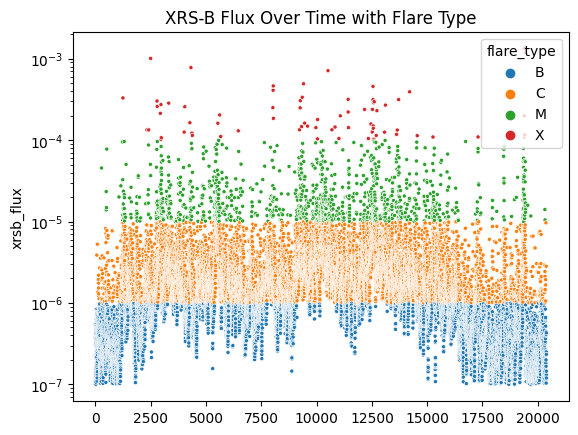

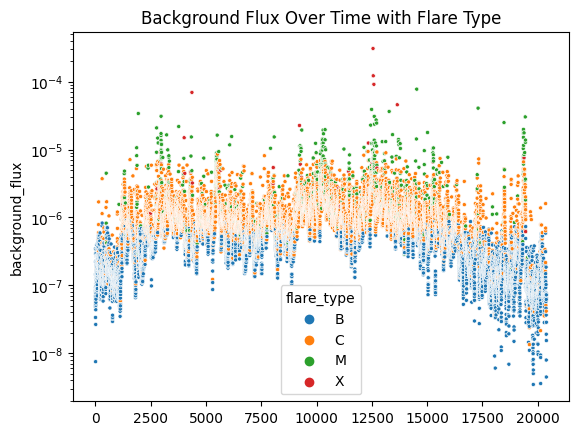

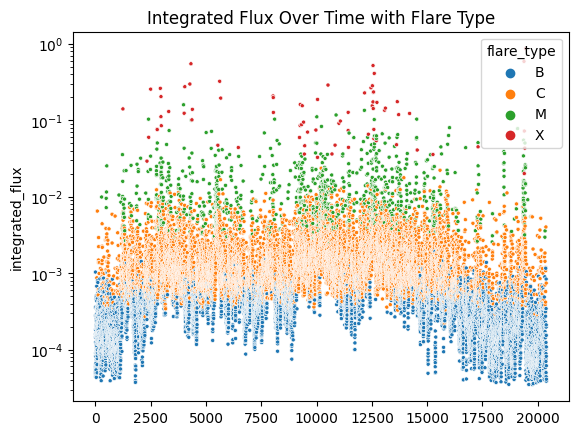

In [248]:
sns.scatterplot(data=subset, x=step, y='xrsb_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("XRS-B Flux Over Time with Flare Type")
plt.show()
sns.scatterplot(data=subset, x=step, y='background_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("Background Flux Over Time with Flare Type")
plt.show()
sns.scatterplot(data=subset, x=step, y='integrated_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("Integrated Flux Over Time with Flare Type")
plt.show()

## Define ML Model:

In [249]:
classifier = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
classifier.fit(trainX,trainY)

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(class_weight={'B': 200, 'C': 200, 'M': 5, 'X': 100})

In [250]:
y_pred = classifier.predict(testX)
test = test.assign(prediction=y_pred)
metrics = {"precision": 0, "recall": 0, "f-score": 0, "support": 0}
p, r, f, s = precision_recall_fscore_support(testY, y_pred, labels=classNames)
metrics['precision'] = p
metrics["recall"] = r
metrics['f-score'] = f
metrics['support'] = s
metrics


{'precision': array([0.99331942, 0.99262102, 0.99676375, 1.        ]),
 'recall': array([0.99748428, 0.99526487, 0.94189602, 0.96153846]),
 'f-score': array([0.99539749, 0.99394119, 0.96855346, 0.98039216]),
 'support': array([2385, 3379,  327,   26], dtype=int64)}

Text(0.5, 1.0, 'Confusion Matrix')

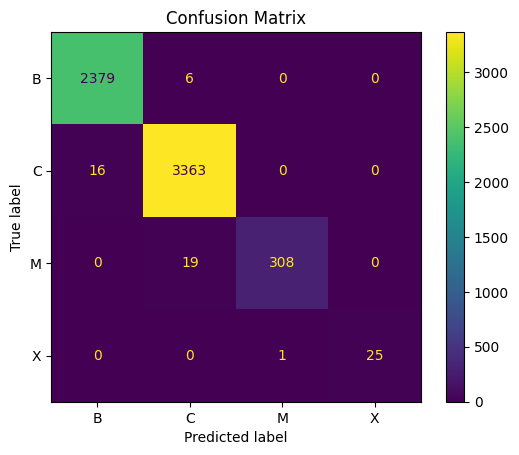

In [251]:
disp = ConfusionMatrixDisplay.from_estimator(classifier, testX, testY, display_labels=classNames)
disp.ax_.set_title("Confusion Matrix")

## Plot Predictions vs. Actual Results

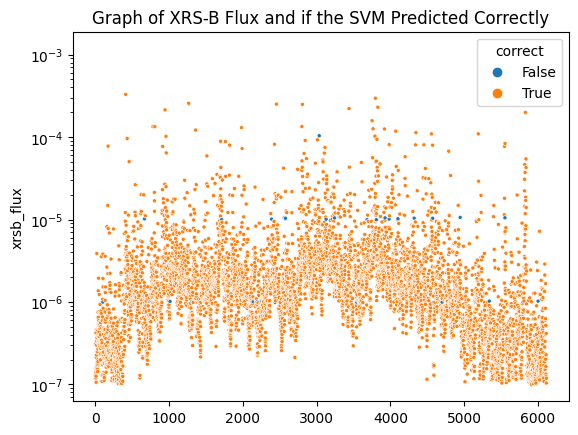

In [252]:
test['correct'] = test['flare_type'] == test['prediction']
sns.scatterplot(data=test, x=[i for i in range(len(test))], y="xrsb_flux", hue='correct', marker='.')
plt.yscale("log")
plt.title("Graph of XRS-B Flux and if the SVM Predicted Correctly")
plt.show()

In [253]:
# Number of false predictions
display(len(test[test.correct == False]))

42

In [254]:
def MonteCarloCrossValidation(n, split, data, features, classes, classNames):
    clf = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
    metrics = {}
    for cls in classNames:
        metrics[cls] = {"p": 0, "r": 0, "f": 0, "s": 0}
    for _ in range(n):
        trainCount = int(split * len(data))
        trainIndices = np.random.choice(data.index,trainCount,replace=False)
        train = data[data.index.isin(trainIndices)]
        test = data[data.index.isin(trainIndices) == False]
        trainX = train[features]
        trainY = train[classes]
        testX = test[features]
        testY = test[classes]

        clf.fit(trainX,trainY)
        predY = clf.predict(testX)
        p, r, f, s = precision_recall_fscore_support(testY, predY)
        for i in range(len(classNames)):
            metrics[classNames[i]]["p"] += p[i]
            metrics[classNames[i]]["r"] += r[i]
            metrics[classNames[i]]["f"] += f[i]
            metrics[classNames[i]]["s"] += s[i]
    for val in metrics.values():
        for key in val.keys():
            val[key] /= n
    return metrics

display("Average p,r,f,s for each class:")
MonteCarloCrossValidation(10,0.7,xrayData,features,classes,classNames)

'Average p,r,f,s for each class:'

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.9939423631954206,
  'r': 0.9974326734077363,
  'f': 0.9956839818216883,
  's': 2337.9},
 'C': {'p': 0.9896318605490603,
  'r': 0.9958241305880738,
  'f': 0.9927177179654258,
  's': 3423.6},
 'M': {'p': 0.9967528155883894,
  'r': 0.9057064886278031,
  'f': 0.949009213257872,
  's': 335.7},
 'X': {'p': 0.8990671185539606,
  'r': 0.9533618750530515,
  'f': 0.9240019525195711,
  's': 19.8}}

## Now, try predicting based on only one feature

We use Monte Carlo Cross Validation to see how our model does with only one feature

In [255]:
display(MonteCarloCrossValidation(4,0.7,xrayData,["flux_standardized"], classes, classNames))
display(MonteCarloCrossValidation(4,0.7,xrayData,["background_standardized"], classes, classNames))
MonteCarloCrossValidation(4,0.7,xrayData,["integrated_standardized"], classes, classNames)

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.9983993162684653,
  'r': 0.9996822033898305,
  'f': 0.999039440061931,
  's': 2350.25},
 'C': {'p': 0.9934511789159907,
  'r': 0.9989053110374108,
  'f': 0.9961704535054443,
  's': 3413.25},
 'M': {'p': 1.0,
  'r': 0.9326853197075593,
  'f': 0.9651388091145487,
  's': 334.75},
 'X': {'p': 0.9682971014492753, 'r': 1.0, 'f': 0.9835748792270531, 's': 18.75}}

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.8281300911321129,
  'r': 0.927691412517111,
  'f': 0.8750557874625315,
  's': 2358.5},
 'C': {'p': 0.8584736187635589,
  'r': 0.8713363118307829,
  'f': 0.8648330383859132,
  's': 3399.75},
 'M': {'p': 0.8821839080459771,
  'r': 0.046555031407681614,
  'f': 0.08791085678965783,
  's': 336.0},
 'X': {'p': 0.03125,
  'r': 0.011904761904761904,
  'f': 0.017241379310344827,
  's': 22.75}}

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.9033938340935103,
  'r': 0.9092898528575191,
  'f': 0.906327904059942,
  's': 2347.75},
 'C': {'p': 0.8649479809394123,
  'r': 0.9329890145594335,
  'f': 0.897673137817227,
  's': 3410.0},
 'M': {'p': 0.9561274509803921,
  'r': 0.0765302347993786,
  'f': 0.1404224823527516,
  's': 336.0},
 'X': {'p': 0.4571698883956098,
  'r': 0.9528508771929826,
  'f': 0.6142097026604069,
  's': 23.25}}

**Result:**  Model seems to perform *better* with only the standardized XRS-B flux. Let's compare that model with the full model, and with a model excluding the background flux, which seems to perform the worst.

In [256]:
display(MonteCarloCrossValidation(10,0.7,xrayData,['flux_standardized'],classes, classNames))
display(MonteCarloCrossValidation(10,0.7,xrayData,['flux_standardized','integrated_standardized'],classes, classNames))
MonteCarloCrossValidation(10,0.7,xrayData,features,classes, classNames)

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.997994305920219, 'r': 1.0, 'f': 0.9989956960271767, 's': 2334.4},
 'C': {'p': 0.9940843140946238,
  'r': 0.9986283821550364,
  'f': 0.9963507586909637,
  's': 3430.7},
 'M': {'p': 1.0, 'r': 0.9342764070673548, 'f': 0.9659949315107614, 's': 328.4},
 'X': {'p': 0.9550585340585339, 'r': 1.0, 'f': 0.9766830888697482, 's': 23.5}}

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.9969007682892113,
  'r': 0.9981646296196842,
  'f': 0.9975315238773476,
  's': 2347.5},
 'C': {'p': 0.9918216442342006,
  'r': 0.997828390839423,
  'f': 0.9948149860367781,
  's': 3413.9},
 'M': {'p': 0.9983784996214595,
  'r': 0.9253221010978019,
  'f': 0.960413327887002,
  's': 330.3},
 'X': {'p': 0.9635907610907612,
  'r': 0.985990860990861,
  'f': 0.9744870873343965,
  's': 25.3}}

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

{'B': {'p': 0.9935334825614399,
  'r': 0.996599890077117,
  'f': 0.995062413805397,
  's': 2324.5},
 'C': {'p': 0.9885300242284742,
  'r': 0.9955876925958813,
  'f': 0.9920445529265534,
  's': 3427.3},
 'M': {'p': 0.9971792963982093,
  'r': 0.9032557486116006,
  'f': 0.947831147262795,
  's': 342.7},
 'X': {'p': 0.9337369460604755,
  'r': 0.9622793872793872,
  'f': 0.9458504501379557,
  's': 22.5}}

The model performs best when only the standardized XRS-B flux is used, so we will simplify our model:

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'precision': array([0.99874372, 0.99469652, 0.99677419, 1.        ]),
 'recall': array([1.        , 0.99911216, 0.94495413, 0.96153846]),
 'f-score': array([0.99937146, 0.99689945, 0.97017268, 0.98039216]),
 'support': array([2385, 3379,  327,   26], dtype=int64)}

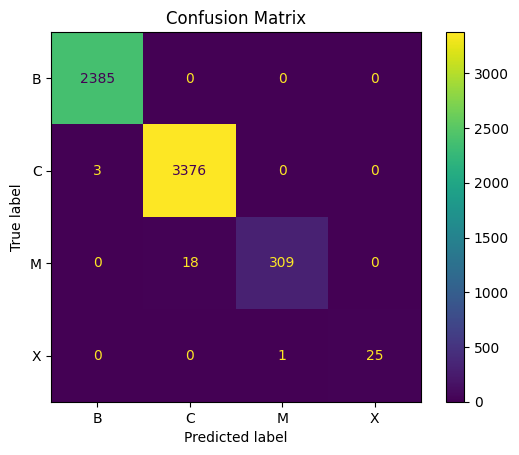

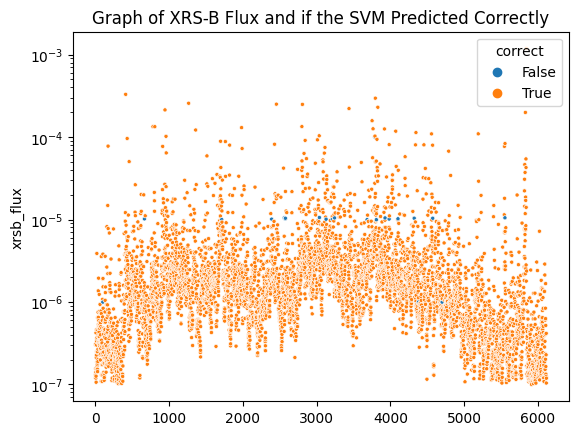

22

In [264]:
# -- DEFINE INPUT AND OUTPUT --
features = ['flux_standardized']
# features = ['xrsb_flux', 'background_flux', 'integrated_flux']
X = xrayData[features]
trainX = train[features]
testX = test[features]

# classNames = ["A","B", "C", "M", "X"]
classNames = ["B", "C", "M", "X"]
classes = ['flare_type']
y = xrayData[classes]
trainY = train[classes]
testY = test[classes]

# -- DEFINE MODEL --
classifier = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
classifier.fit(trainX,trainY)

# -- PREDICT --
y_pred = classifier.predict(testX)
test = test.assign(prediction=y_pred)
metrics = {"precision": 0, "recall": 0, "f-score": 0, "support": 0}
p, r, f, s = precision_recall_fscore_support(testY, y_pred, labels=classNames)
metrics['precision'] = p
metrics["recall"] = r
metrics['f-score'] = f
metrics['support'] = s
display(metrics)

# -- MAKE PLOTS --
disp = ConfusionMatrixDisplay.from_estimator(classifier, testX, testY, display_labels=classNames)
disp.ax_.set_title("Confusion Matrix")
plt.show()

test['correct'] = test['flare_type'] == test['prediction']
sns.scatterplot(data=test, x=[i for i in range(len(test))], y="xrsb_flux", hue='correct', marker='.')
plt.yscale("log")
plt.title("Graph of XRS-B Flux and if the SVM Predicted Correctly")
plt.show()

# Number of false predictions
display(len(test[test.correct == False]))